In [12]:
import numpy as np
import h5py

In [13]:
# Tweak here matplotlib style
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif'].insert(0, 'Arial')
mpl.rcParams['font.size'] = 14

In [14]:

import pycorrelate as pyc
pyc.__version__



'0.3'

In [15]:
import lmfit
lmfit.__version__

'0.9.7'

In [16]:
fname = 'LS3.h5'
h5 = h5py.File(fname)
unit = h5['photon_data']['timestamps_specs']['timestamps_unit'][()]
unit

6.2496875156242192e-08

In [17]:
detectors = h5['photon_data']['detectors'][:]
timestamps = h5['photon_data']['timestamps'][:]
t = timestamps[detectors == 0]
u = timestamps[detectors == 1]
# compute lags in sec. then convert to timestamp units
bins_per_dec = 20
bins = pyc.make_loglags(-6, 1, bins_per_dec)[bins_per_dec // 2:] / unit
print('Number of time-lag bins:', bins.size)


Number of time-lag bins: 131


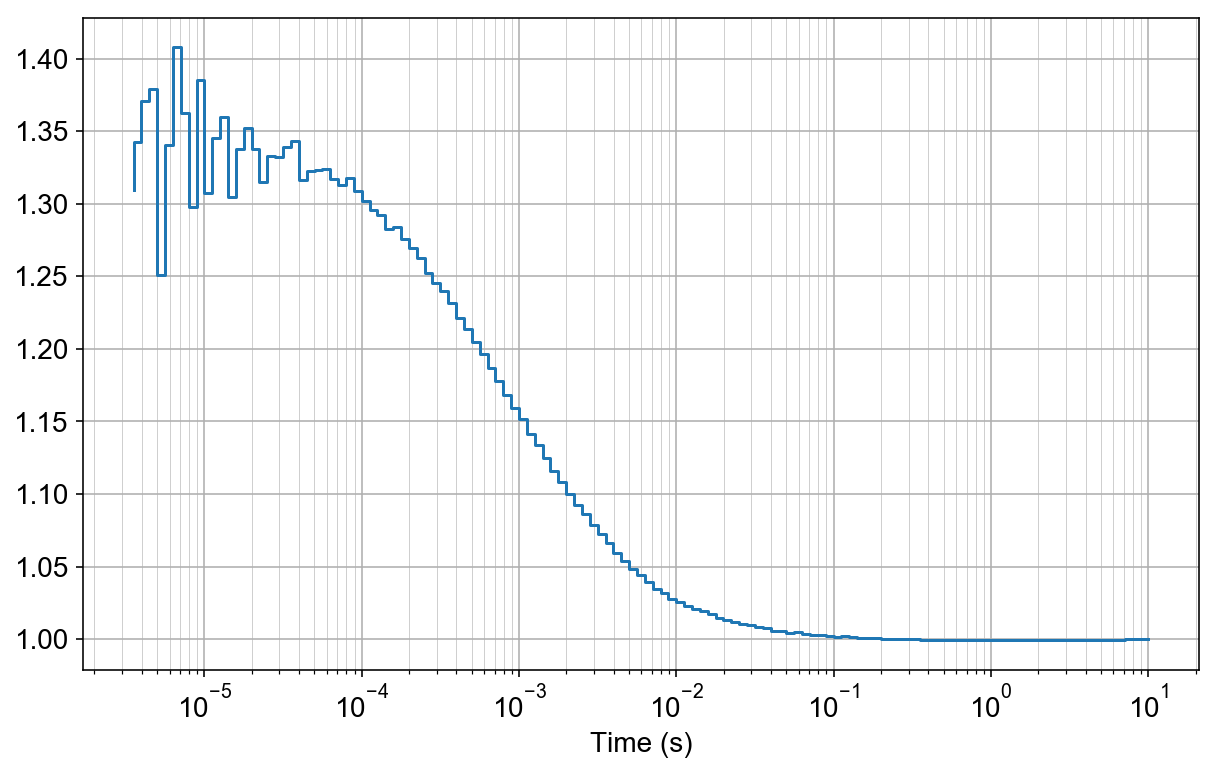

In [18]:

Gn = pyc.pcorrelate(t, u, bins, normalize=True)



fig, ax = plt.subplots(figsize=(10, 6))
plt.semilogx(bins[1:]*unit, Gn, drawstyle='steps-pre')
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3);



In [19]:
def diffusion_2d(timelag, tau_diff, A0):
    return 1 + A0 * 1/(1 + timelag/tau_diff)

def diffusion_3d(timelag, tau_diff, A0, waist_z_ratio=0.1):
    return (1 + A0 * 1/(1 + timelag/tau_diff) *
            1/np.sqrt(1 + waist_z_ratio**2 * timelag/tau_diff))

In [20]:
tau = 0.5 * (bins[1:] + bins[:-1]) * unit

In [21]:
model = lmfit.Model(diffusion_2d)
params = model.make_params(A0=1, tau_diff=1e-3)
params['A0'].set(min=0.01, value=1)
params['tau_diff'].set(min=1e-6, value=1e-3)
#params['waist_z_ratio'].set(value=1/6, vary=False)  # 3D model only

weights = np.ones_like(Gn)
#weights = np.log(np.sqrt(G*np.diff(bins)))  # and example of using weights
fitres = model.fit(Gn, timelag=tau, params=params, method='least_squares',
                   weights=weights)
print('\nList of fitted parameters for %s: \n' % model.name)
fitres.params.pretty_print(colwidth=10, columns=['value', 'min', 'max'])


List of fitted parameters for Model(diffusion_2d): 

Name           Value        Min        Max
A0            0.3432       0.01        inf
tau_diff   0.0008211      1e-06        inf


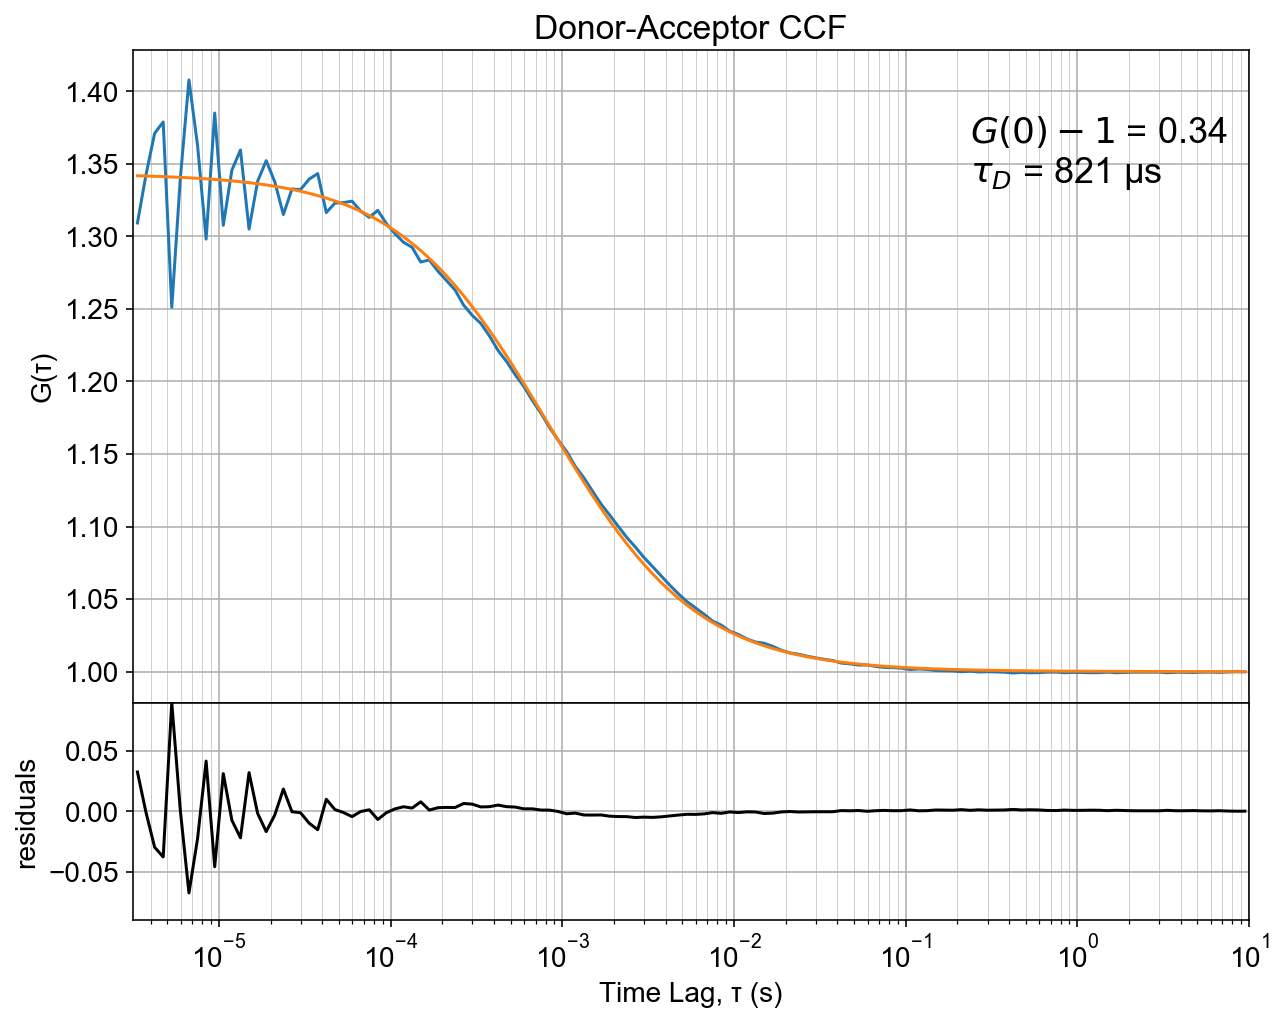

In [22]:


fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True,
                       gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=0)
ax[0].semilogx(tau, Gn)
for a in ax:
    a.grid(True); a.grid(True, which='minor', lw=0.3)
ax[0].plot(tau, fitres.best_fit)
ax[1].plot(tau, fitres.residual*weights, 'k')
ym = np.abs(fitres.residual*weights).max()
ax[1].set_ylim(-ym, ym)
ax[1].set_xlim(bins[0]*unit, bins[-1]*unit);
tau_diff_us = fitres.values['tau_diff'] * 1e6
msg = ((r'$G(0)-1$ = {A0:.2f}'+'\n'+r'$\tau_D$ = {tau_diff_us:.0f} μs')
       .format(A0=fitres.values['A0'], tau_diff_us=tau_diff_us))
ax[0].text(.75, .9, msg,
           va='top', ha='left', transform=ax[0].transAxes, fontsize=18);
ax[0].set_ylabel('G(τ)')
ax[1].set_ylabel('residuals')
ax[0].set_title('Donor-Acceptor CCF')
ax[1].set_xlabel('Time Lag, τ (s)');

